In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

C:\Users\Administrator\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/train.csv', sep=',', header=0)
print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def split_data(df):

    train=df.sample(frac=0.8,random_state=42)
    val=df.drop(train.index)
    
    return train, val

In [4]:
df_train, df_val = split_data(df)

In [5]:
def restore_dimensions(df, prediction=False):   
    
    X = df.loc[:, 'pixel0':'pixel783']
    X = X.values 
    m = X.shape[0]   
    X = np.reshape(X, (m, 28, 28, 1))
    
    if prediction:
        Y = None
    else:
        y = df.loc[:, 'label']
        Y = pd.get_dummies(y, columns = ['label'])
        Y  = Y.values
        Y = np.reshape(Y, (m, 10))
            
    return X, Y

In [6]:
X_train, Y_train = restore_dimensions(df_train)
X_val, Y_val = restore_dimensions(df_val)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = 10

print("Number of training examples = " + str(X_train.shape[0]))
print("Number of validation examples = " + str(X_val.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("Y_val shape: " + str(Y_val.shape))
print("Input shape: " + str(input_shape))
print("Number of classes: " + str(num_classes))
print("X_train min: " + str(np.min(X_train)))
print("X_train max: " + str(np.max(X_train)))
print("X_train mean: " + str(np.mean(X_train)))
print("X_train std: " + str(np.std(X_train)))

Number of training examples = 33600
Number of validation examples = 8400
X_train shape: (33600, 28, 28, 1)
Y_train shape: (33600, 10)
X_val shape: (8400, 28, 28, 1)
Y_val shape: (8400, 10)
Input shape: (28, 28, 1)
Number of classes: 10
X_train min: 0
X_train max: 255
X_train mean: 33.448279997266766
X_train std: 78.71670889973403


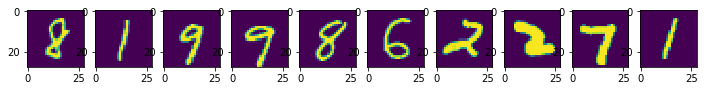

In [7]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(10):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5)

datagen = ImageDataGenerator(
        rescale=1.0/255, # Normalize input
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [ ]:
datagen.fit(X_train)
epochs = 35
batch_size = 64

h = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        epochs = epochs, 
                        validation_data = (X_val, Y_val),
                        verbose = 1, 
                        steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/35
525/525 [==============================] - 101s 192ms/step - loss: 0.4041 - acc: 0.8737 - val_loss: 0.0986 - val_acc: 0.9695

In [ ]:
df_test = pd.read_csv('C:/GitHub/kaggle/digit-recognizer/data/test.csv', sep=',', header=0)
df_test.head(1)

In [ ]:
X_test, _ = restore_dimensions(df_test, prediction=True)
X_test = preprocess_data(X_test)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predicted_classes)+1)),
                         "Label": predicted_classes})
submissions.to_csv("./predictions/mnist_predicitons.csv", index=False, header=True)